# Contrastive Learning on the MNIST Data Set

# 0 Hyperparameters

## 0.1 Contrastive Transformations
- RandomHorizontalFlip()
- RandomResizedCrop(size=28, scale=(0.8, 1.0)) 
- RandomApply([ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8), 
- RandomGrayscale(p=0.2), 
- GaussianBlur(kernel_size=9), 
- ToTensor(), 
- Normalize((0.1307,), (0.3081,))

## 0.2 Pretraining Batch Size

- pretraining_batch_size = 256

In [173]:
pretraining_batch_size = 256

## 0.3 Model Architecture

- conv1 = nn.Conv2d(1, 20, 5, 1)
- conv2 = nn.Conv2d(20, 50, 5, 1)
- fc1 = nn.Linear(4 * 4 * 50, 500)
- fc2 = nn.Linear(500, 10)

CNN Base Encoder:
- x = torch.relu(self.conv1(x))  # 1x28x28 -> 20x24x24
- x = torch.max_pool2d(x, 2, 2)  # 20x24x24 -> 20x12x12
- x = torch.relu(self.conv2(x))  # 20x12x12 -> 50x8x8
- x = torch.max_pool2d(x, 2, 2)  # 50x8x8 -> 50x4x4
- x = x.view(-1, 4 * 4 * 50)     # 50x4x4 -> 800

Projection Head:
- x = torch.relu(self.fc1(x))    # 800 -> 500
- x = self.fc2(x)                # 500 -> 10

# 1 Imports

## 1.1 Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import time, os, random, copy


In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, RandomCrop, RandomResizedCrop, ColorJitter, GaussianBlur, RandomApply, RandomGrayscale


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [8]:
from sklearn.manifold import TSNE

## 1.2 Setting the Seed for Reproducibility

In [9]:
def set_seed(seed = 16):
    np.random.seed(seed)
    torch.manual_seed(seed)

# 2 Preparing the MNIST Data Set

## 2.1 Defining Transformations

In [147]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307), (0.3081))])

contrastive_transform = Compose(
    [RandomHorizontalFlip(), 
     RandomResizedCrop(size=28, scale=(0.8, 1.0)), 
     RandomApply([ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8), 
     RandomGrayscale(p=0.2), 
     GaussianBlur(kernel_size=9), 
     ToTensor(), 
     Normalize((0.1307,), (0.3081,))])

class CLTransformations(object):
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, sample):
        xi = self.transform(sample)
        xj = self.transform(sample)
        return xi, xj
    
contrastive_transform = CLTransformations(contrastive_transform)

- why those normalisations?
- create a table with parameters

## 2.2 Defining Dataset Size 

In [148]:
dataset_size = 5000

## 2.3 Creating DataLoaders

In [149]:
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=contrastive_transform)
trainset = torch.utils.data.Subset(trainset, range(dataset_size))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=pretraining_batch_size,
                                          shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=contrastive_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=pretraining_batch_size,
                                         shuffle=False)

classes = ('zero', 'one', 'two', 'three', 'four',
           'five', 'six', 'seven', 'eight', 'nine')

## 2.4 Visualising the Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.28789353..1.9107434].


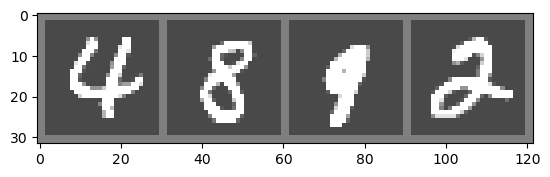

four  eight nine  two  


In [150]:
# loading the data
show_batch_size = 4
show_trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
show_trainloader = torch.utils.data.DataLoader(show_trainset, batch_size=show_batch_size,
                                          shuffle=True, num_workers=2)

show_testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
show_testloader = torch.utils.data.DataLoader(show_testset, batch_size=show_batch_size,
                                         shuffle=False, num_workers=2)

classes = ('zero', 'one', 'two', 'three', 'four',
           'five', 'six', 'seven', 'eight', 'nine')

# getting random training images
dataiter = iter(show_trainloader)
images, labels = next(dataiter)

# show images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(show_batch_size)))

- what does imshow do?

# 3 Contrastive Pretraining

## 3.1 Defining and Initialising the Model

### 3.1.1 Base Encoder and Projection Head

In [187]:
class ProjectionHead(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ProjectionHead, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.layers = nn.Sequential(
            self.fc1, nn.ReLU(),        # 800 -> 500
            self.fc2)                   # 500 -> 10

    def forward(self, x):
        x = self.layers(x)
        return x

class CLModel(nn.Module):
    def __init__(self):
        super(CLModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.projection_head = ProjectionHead(800, 500, 10)

    def forward(self, x):
        # CNN Base Encoder
        x = torch.relu(self.conv1(x))  
        x = torch.max_pool2d(x, 2, 2)  # 20x24x24 -> 20x12x12
        x = torch.relu(self.conv2(x))  # 20x12x12 -> 50x8x8
        x = torch.max_pool2d(x, 2, 2)  # 50x8x8 -> 50x4x4
        x = x.view(-1, 4 * 4 * 50)     # 50x4x4 -> 800

        # Projection Head
        x = self.projection_head(x)                
        return x
    
    def forward_no_projection_head(self, x):
        # CNN Base Encoder
        x = torch.relu(self.conv1(x))  
        x = torch.max_pool2d(x, 2, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        return x

### 3.1.2 Contrastive Loss

In [188]:
def contrastive_loss(hi, hj, temperature=0.5):
    # concatenate two sets of features
    h = torch.cat([hi, hj], dim=0)

    # calculate cosine similarity
    cos_sim = F.cosine_similarity(h.unsqueeze(1), h.unsqueeze(0), dim=2)

    # remove self-similarity form the matrix
    cos_sim = cos_sim.masked_fill(torch.eye(cos_sim.shape[0]).bool(), -1e9)

    # for each image, find the positive pair
    positive_pairs = torch.cat([torch.arange(hi.shape[0], 2*hi.shape[0]), torch.arange(hi.shape[0])], dim=0)

    # compute the InfoNCE loss
    loss = F.cross_entropy(cos_sim / temperature, positive_pairs)
    return loss

- why -1e9

### 3.1.3 Initialising Model

In [189]:
model = CLModel()

### 3.1.4 Initialising the Optimiser

In [190]:
learning_rate = 0.001
optimiser = optim.Adam(model.parameters(), lr=learning_rate)

## 3.2 Training

In [191]:
for epoch in range(20):
    running_loss = 0.0
    batch = 0
    for (xi, xj), _ in trainloader:
        batch += 1

        # zero the parameter gradients
        optimiser.zero_grad()

        # forward 
        hi, hj = model(xi), model(xj)
        loss = contrastive_loss(hi, hj)

        # loss
        running_loss += loss.item()

        # backward + optimise
        loss.backward()
        optimiser.step()

    # print statistics
    print(f'Epoch {epoch}, Loss: {running_loss / batch}')

Epoch 0, Loss: 5.183010244369507
Epoch 1, Loss: 4.878868103027344
Epoch 2, Loss: 4.79930546283722
Epoch 3, Loss: 4.722259259223938
Epoch 4, Loss: 4.674849963188171
Epoch 5, Loss: 4.652444076538086
Epoch 6, Loss: 4.630107831954956
Epoch 7, Loss: 4.5965351343154905
Epoch 8, Loss: 4.582862269878388
Epoch 9, Loss: 4.572400486469268
Epoch 10, Loss: 4.555621969699859
Epoch 11, Loss: 4.552079820632935
Epoch 12, Loss: 4.544319927692413
Epoch 13, Loss: 4.540510141849518
Epoch 14, Loss: 4.530709671974182
Epoch 15, Loss: 4.5255736947059635
Epoch 16, Loss: 4.522501242160797
Epoch 17, Loss: 4.516883659362793
Epoch 18, Loss: 4.512508749961853
Epoch 19, Loss: 4.511414754390716


# 4 Linear Classification

## 4.1 With Contrastive Pretraining

### 4.1.1 Loading the Pretrained Data

In [192]:
def extract_features(dataloader, model):
    features = []
    labels = []

    with torch.no_grad():
        for xi, target in dataloader:
            feature = model.forward_no_projection_head(xi)
            features.append(feature)
            labels.append(target)

    return torch.cat(features), torch.cat(labels)

In [193]:
linear_batch_size = 256

In [194]:
linear_transforms = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

linear_dataset = datasets.MNIST('./data', train=True, download=True, transform=linear_transforms)
linear_trainloader = DataLoader(linear_dataset, batch_size=linear_batch_size, shuffle=True)

features, labels = extract_features(linear_trainloader, model)
linear_dataset = torch.utils.data.TensorDataset(features, labels)
linear_trainloader = DataLoader(linear_dataset, batch_size=linear_batch_size, shuffle=True)

### 4.1.2 Initialising the Linear Classifier and Optimiser

In [195]:
linear_learning_rate = 0.1

In [198]:
linear_classifier = nn.Linear(4 * 4 * 50, 10)
linear_optimiser = optim.Adam(linear_classifier.parameters(), lr=linear_learning_rate)

### 4.1.3 Linear Classification With Contrastive Pretraining

In [199]:
for epoch in range(100):
    running_loss = 0.0
    total = 0
    correct = 0
    for batch, data in enumerate(linear_trainloader, 0):
        features, labels = data

        # zero the parameter gradients
        linear_optimiser.zero_grad()

        # forward 
        outputs = linear_classifier(features)

        # loss
        loss = nn.CrossEntropyLoss()(outputs, labels)

        # accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # backward
        loss.backward()
        running_loss += loss.item()

        # optimise
        linear_optimiser.step()

    # print statistics
    accuracy = correct / total * 100
    print('[Epoch: %d] loss: %.5f, accuracy: %.3f' % (epoch + 1, running_loss / (batch+1), accuracy))

[Epoch: 1] loss: 0.29376, accuracy: 94.793
[Epoch: 2] loss: 0.17906, accuracy: 96.972
[Epoch: 3] loss: 0.16473, accuracy: 97.290
[Epoch: 4] loss: 0.16382, accuracy: 97.660
[Epoch: 5] loss: 0.16249, accuracy: 97.905
[Epoch: 6] loss: 0.16378, accuracy: 97.900
[Epoch: 7] loss: 0.14519, accuracy: 98.200
[Epoch: 8] loss: 0.13884, accuracy: 98.302
[Epoch: 9] loss: 0.15767, accuracy: 98.210
[Epoch: 10] loss: 0.13330, accuracy: 98.508
[Epoch: 11] loss: 0.11651, accuracy: 98.630
[Epoch: 12] loss: 0.12480, accuracy: 98.537
[Epoch: 13] loss: 0.13676, accuracy: 98.512
[Epoch: 14] loss: 0.11128, accuracy: 98.750
[Epoch: 15] loss: 0.13256, accuracy: 98.632
[Epoch: 16] loss: 0.12692, accuracy: 98.637
[Epoch: 17] loss: 0.11972, accuracy: 98.822
[Epoch: 18] loss: 0.13074, accuracy: 98.670
[Epoch: 19] loss: 0.12536, accuracy: 98.763
[Epoch: 20] loss: 0.09642, accuracy: 98.992
[Epoch: 21] loss: 0.12821, accuracy: 98.773
[Epoch: 22] loss: 0.10557, accuracy: 98.993
[Epoch: 23] loss: 0.10855, accuracy: 98.9

## 4.2 Without Contrastive Pretraining

### 4.2.1 Loading the Data

In [101]:
linear_dataset = datasets.MNIST('./data', train=True, download=True, transform=linear_transforms)
linear_trainloader = DataLoader(linear_dataset, batch_size=linear_batch_size, shuffle=True)


### 4.1.2 Initialising the Linear Classifier and Optimiser

In [102]:
linear_classifier = nn.Linear(28*28, 10)
linear_optimiser = optim.Adam(linear_classifier.parameters(), lr=linear_learning_rate)

### 4.1.3 Linear Classification Without Contrastive Pretraining

In [103]:
for epoch in range(100):
    running_loss = 0.0
    total = 0
    correct = 0
    for batch, data in enumerate(linear_trainloader, 0):
        features, labels = data

        # zero the parameter gradients
        linear_optimiser.zero_grad()

        # forward
        features = features.view(features.size(0), -1)
        outputs = linear_classifier(features)

        # loss
        loss = nn.CrossEntropyLoss()(outputs, labels)

        # accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # backward
        loss.backward()
        running_loss += loss.item()

        # optimise
        linear_optimiser.step()

    # print statistics
    accuracy = correct / total * 100
    print('[Epoch: %d] loss: %.5f, accuracy: %.3f' % (epoch + 1, running_loss / (batch+1), accuracy))

[Epoch: 1] loss: 0.66095, accuracy: 82.643
[Epoch: 2] loss: 0.36965, accuracy: 89.618
[Epoch: 3] loss: 0.33349, accuracy: 90.492
[Epoch: 4] loss: 0.31657, accuracy: 90.938
[Epoch: 5] loss: 0.30648, accuracy: 91.222
[Epoch: 6] loss: 0.29840, accuracy: 91.530
[Epoch: 7] loss: 0.29253, accuracy: 91.792
[Epoch: 8] loss: 0.29005, accuracy: 91.772
[Epoch: 9] loss: 0.28635, accuracy: 91.918
[Epoch: 10] loss: 0.28342, accuracy: 91.972
[Epoch: 11] loss: 0.28029, accuracy: 92.168
[Epoch: 12] loss: 0.27812, accuracy: 92.198
[Epoch: 13] loss: 0.27644, accuracy: 92.307
[Epoch: 14] loss: 0.27563, accuracy: 92.263
[Epoch: 15] loss: 0.27143, accuracy: 92.362
[Epoch: 16] loss: 0.27220, accuracy: 92.343
[Epoch: 17] loss: 0.27021, accuracy: 92.478
[Epoch: 18] loss: 0.27040, accuracy: 92.428
[Epoch: 19] loss: 0.26772, accuracy: 92.538
[Epoch: 20] loss: 0.26672, accuracy: 92.493
[Epoch: 21] loss: 0.26613, accuracy: 92.520
[Epoch: 22] loss: 0.26517, accuracy: 92.648
[Epoch: 23] loss: 0.26526, accuracy: 92.5